In [54]:
import pandas as pd
import numpy as np
import multiprocessing
import nltk
from nltk.corpus import stopwords
from nltk import FreqDist
from nltk.stem.porter import PorterStemmer
from collections import Counter
import random
import re
import matplotlib.pyplot as plt
import seaborn as sns
import gensim.models.word2vec as w2v
from gensim.models import LdaModel
from gensim import models, corpora, similarities
import sklearn.manifold
import time

%matplotlib inline
sns.set_style("darkgrid")

In [2]:
df = pd.read_csv('Fake_news_Kaggle.csv', usecols = ['uuid','author','title','text','language','site_url','country'])
#considering source of data
df = df[df.language == 'english']
df['title'].fillna(value="", inplace=True)
df.dropna(axis=0, inplace=True, subset=['text'])
df = df.sample(frac=1.0) # shuffle the data
df.reset_index(drop=True,inplace=True)
df.head()

,uuid,author,title,text,language,site_url,country
0,fdf1cf70ce470729ed12cb16a7117ea582b3a44c,Aaron Kesel,Obama’s Brother Malik Supports Trump AND Wants...,"We Are Change \nObama’s brother from Kenya, Ma...",english,wearechange.org,US
1,38507a211cbae410b9977138ffeb187001d00bcb,Cherese Jackson,Politics Should Not Ruin Thanksgiving Dinner,The 2016 presidential election has left the co...,english,guardianlv.com,US
2,102fd8d66e09434b5b54d16a605b772bc8acb375,NaN,Trump teaches his supporters how to vote corre...,Trump teaches his supporters how to vote corre...,english,pravdareport.com,RU
3,bb33501cef91743176e9e7599a3b8529e8594ee5,admin,PROFESSOR WHO PREDICTED LAST FIVE ELECTIONS SA...,Paul Joseph Watson Political science professor...,english,jewsnews.co.il,US
4,724124e37ea16cb8f27deb36b45ea0b239ba96e1,Andrew Anglin,The Guardian is Going Friggin Nuts Over Calais,The Guardian is Going Friggin Nuts Over Calais...,english,dailystormer.com,US


In [3]:
df.shape

(12357, 7)

### Tokenization

In [4]:
def sent_tokenizer(text):
    """
    Function to tokenize sentences
    """
    text = nltk.sent_tokenize(text)
    return text

def sentence_cleaner(text):
    """
    Function to lower case remove all websites, emails and non alphabetical characters
    """
    new_text = []
    for sentence in text:
        sentence = sentence.lower()
        sentence = re.sub("((\S+)?(http(s)?)(\S+))|((\S+)?(www)(\S+))|((\S+)?(\@)(\S+)?)", " ", sentence)
        sentence = re.sub("[^a-z ]", "", sentence)
        sentence = nltk.word_tokenize(sentence)
        sentence = [word for word in sentence if len(word)>1] # exclude 1 letter words
        new_text.append(sentence)
    return new_text

def apply_all(text):
    return sentence_cleaner(sent_tokenizer(text))

df['sent_tokenized_text'] = df['text'].apply(apply_all)

In [5]:
df.head()

,uuid,author,title,text,language,site_url,country,sent_tokenized_text
0,fdf1cf70ce470729ed12cb16a7117ea582b3a44c,Aaron Kesel,Obama’s Brother Malik Supports Trump AND Wants...,"We Are Change \nObama’s brother from Kenya, Ma...",english,wearechange.org,US,"[[we, are, change, obamas, brother, from, keny..."
1,38507a211cbae410b9977138ffeb187001d00bcb,Cherese Jackson,Politics Should Not Ruin Thanksgiving Dinner,The 2016 presidential election has left the co...,english,guardianlv.com,US,"[[the, presidential, election, has, left, the,..."
2,102fd8d66e09434b5b54d16a605b772bc8acb375,NaN,Trump teaches his supporters how to vote corre...,Trump teaches his supporters how to vote corre...,english,pravdareport.com,RU,"[[trump, teaches, his, supporters, how, to, vo..."
3,bb33501cef91743176e9e7599a3b8529e8594ee5,admin,PROFESSOR WHO PREDICTED LAST FIVE ELECTIONS SA...,Paul Joseph Watson Political science professor...,english,jewsnews.co.il,US,"[[paul, joseph, watson, political, science, pr..."
4,724124e37ea16cb8f27deb36b45ea0b239ba96e1,Andrew Anglin,The Guardian is Going Friggin Nuts Over Calais,The Guardian is Going Friggin Nuts Over Calais...,english,dailystormer.com,US,"[[the, guardian, is, going, friggin, nuts, ove..."


In [6]:
all_words = [word for item in list(df['sent_tokenized_text']) for word in item]
all_words = [subitem for item in all_words for subitem in item]

fdist = FreqDist(all_words) # finding frequency of words
fdist

FreqDist({'the': 474135, 'to': 223585, 'of': 223417, 'and': 205429, 'in': 149168, 'that': 108577, 'is': 101033, 'for': 72155, 'on': 59705, 'it': 56437, ...})

In [7]:
fdist.most_common(20)

[('the', 474135),
 ('to', 223585),
 ('of', 223417),
 ('and', 205429),
 ('in', 149168),
 ('that', 108577),
 ('is', 101033),
 ('for', 72155),
 ('on', 59705),
 ('it', 56437),
 ('as', 53156),
 ('with', 50873),
 ('are', 48235),
 ('this', 47839),
 ('by', 44737),
 ('be', 43030),
 ('was', 41690),
 ('have', 39794),
 ('not', 38503),
 ('from', 34717)]

In [9]:
def doc_length(text):
    return len([word for sent in text for word in sent])

df['doc_len'] = df['sent_tokenized_text'].apply(doc_length)
doc_lengths = list(df['doc_len'])
df.drop(labels='doc_len', axis=1, inplace=True)

In [10]:
print("length of list:",len(doc_lengths),
      "\naverage document length", np.average(doc_lengths),
      "\nmaximum document length", max(doc_lengths))

length of list: 12357 
average document length 615.7995468155701 
maximum document length 22894


In [11]:
all_sentences = list(df['sent_tokenized_text'])
all_sentences = [subitem for item in all_sentences for subitem in item]
all_sentences[:2] # print first 5 sentences

[['we',
  'are',
  'change',
  'obamas',
  'brother',
  'from',
  'kenya',
  'malik',
  'wants',
  'him',
  'to',
  'pardon',
  'julian',
  'assange'],
 ['it',
  'seems',
  'hate',
  'of',
  'the',
  'international',
  'whistleblower',
  'organization',
  'doesnt',
  'run',
  'in',
  'the',
  'family']]

### Word2Vec

In [12]:
num_features = 300 # number of dimensions
# if any words appear less than min_word_count amount of times, we ignore it

min_word_count = 10
num_workers = multiprocessing.cpu_count()
context_size = 7 # window size around target word to analyse
downsampling = 1e-3 # downsample frequent words
seed = 1 


fake_news = w2v.Word2Vec(
    sg=1,
    seed=seed,
    workers=num_workers,
    vector_size=num_features,
    min_count=min_word_count,
    window=context_size,
    sample=downsampling
)

In [13]:
fake_news.build_vocab(all_sentences)

In [14]:
fake_news.corpus_count

348219

In [15]:
fake_news.train(all_sentences, total_examples=fake_news.corpus_count, epochs=fake_news.epochs)

all_word_vectors_matrix = fake_news.wv.vectors

all_word_vectors_matrix.shape

(25818, 300)

### TSNE

In [16]:
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0) #for visualization is lower dimension
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)

In [17]:
fake_news.wv.index_to_key

['the',
 'to',
 'of',
 'and',
 'in',
 'that',
 'is',
 'for',
 'on',
 'it',
 'as',
 'with',
 'are',
 'this',
 'by',
 'be',
 'was',
 'have',
 'not',
 'from',
 'you',
 'they',
 'has',
 'we',
 'at',
 'he',
 'but',
 'an',
 'will',
 'or',
 'us',
 'their',
 'his',
 'who',
 'all',
 'its',
 'trump',
 'if',
 'about',
 'clinton',
 'people',
 'what',
 'been',
 'more',
 'one',
 'were',
 'can',
 'would',
 'which',
 'so',
 'our',
 'there',
 'her',
 'no',
 'out',
 'when',
 'said',
 'had',
 'hillary',
 'up',
 'she',
 'your',
 'just',
 'new',
 'do',
 'other',
 'like',
 'into',
 'them',
 'also',
 'now',
 'than',
 'over',
 'some',
 'these',
 'even',
 'only',
 'time',
 'how',
 'after',
 'world',
 'election',
 'because',
 'state',
 'many',
 'president',
 'government',
 'most',
 'any',
 'could',
 'being',
 'war',
 'my',
 'against',
 'states',
 'those',
 'years',
 'american',
 'obama',
 'media',
 'get',
 'first',
 'then',
 'while',
 'know',
 'very',
 'campaign',
 'may',
 'him',
 'two',
 'russia',
 'should',
 

In [18]:
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[fake_news.wv.key_to_index[word]])
            for word in fake_news.wv.index_to_key
        ]
    ],
    columns=["word", "x", "y"]
)

In [19]:
points.x

0        -8.838803
1       -10.144380
2        -8.717046
3        -8.950368
4        -7.588693
           ...    
25813     8.909433
25814   -20.378023
25815    10.004908
25816     5.659219
25817    16.368248
Name: x, Length: 25818, dtype: float64

In [20]:
def plot_region(x_bounds, y_bounds):
    """
    This function defines regions of the tsne map
    in which to zoom in on
    """
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) & 
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
    print(slice)
    
    ax = slice.plot.scatter("x", "y", s=35, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)
    plt.show()

In [22]:
points.head(10)

,word,x,y
0,the,-8.838803,2.376964
1,to,-10.144380,4.982477
2,of,-8.717046,2.456125
3,and,-8.950368,2.420365
4,in,-7.588693,-13.360847
5,that,-26.785755,13.520484
6,is,-32.008041,10.346768
7,for,-10.573234,3.219806
8,on,-6.957780,-20.686989
9,it,-16.712194,10.203721


In [23]:
sns.set_context("poster")

<AxesSubplot:title={'center':'TSNE Map of word2vec embeddings'}, xlabel='x', ylabel='y'>

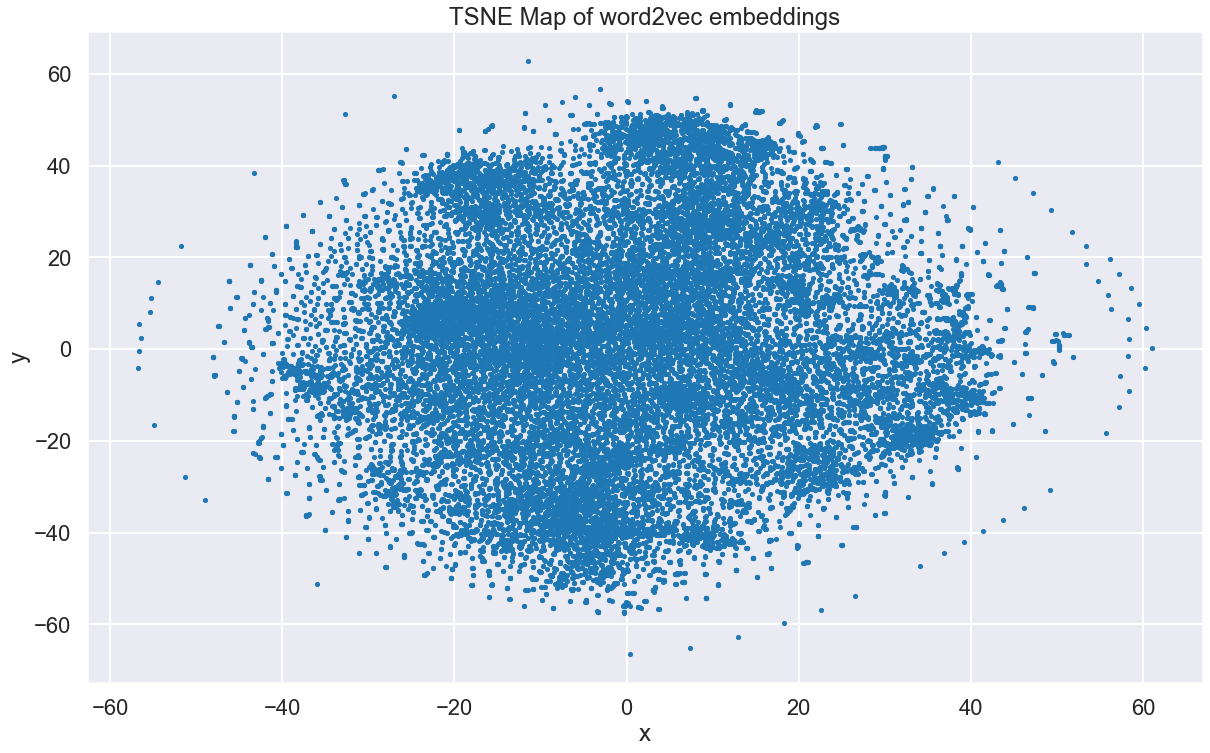

In [24]:
points.plot.scatter("x", "y", s=10, figsize=(20, 12), title="TSNE Map of word2vec embeddings")


             word          x         y
1774       launch  46.323376  3.636093
1886   electronic  46.597301  4.350610
1948      devices  46.601639  4.369095
5604          emp  46.340389  3.723516
9401      disable  46.345043  3.738183
18971     readies  46.342945  3.728553
22183      yorkin  46.392448  3.859143


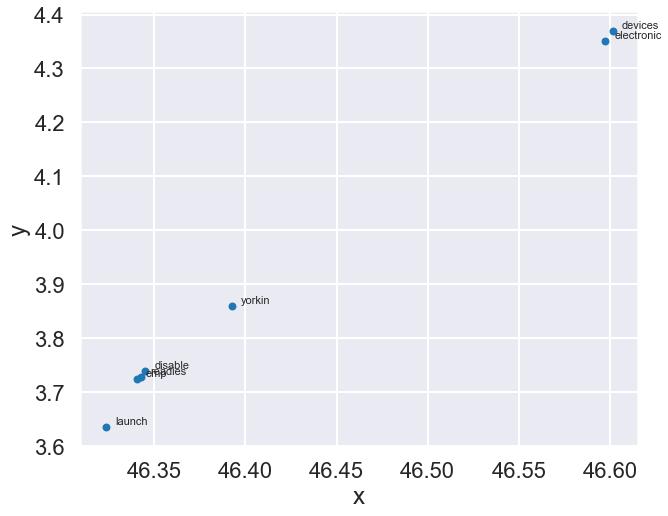

In [50]:
plot_region((44,47), (3,6)) # seeing a group of words

               word         x         y
1880           fine -9.560734  5.903897
2234         victim -9.097304  5.303593
2951    accountable -8.201812  5.999490
4145        wanting -8.387768  6.613368
5483         abused -9.239492  6.410406
5901       punished -8.200459  6.466430
7568             pc -9.391630  5.042128
7859       silenced -8.406754  6.468667
8572      powerless -7.891228  6.307204
8767           lest -8.393090  6.635342
9898       surround -7.779187  5.633736
11846    dismissing -7.717577  5.309358
12011        shamed -8.359643  6.382764
12063        erased -7.018205  5.442559
13242        liable -8.527104  5.809629
13534  powersthatbe -7.998112  6.801755
14199   indifferent -8.275713  6.698147
14208   perpetrator -9.035397  5.321281
14286    victimized -8.862319  6.567510
15626   miscarriage -7.265072  5.542928
15711   traumatized -9.801170  6.533651
16631       coerced -8.204080  6.564259
16768       misused -8.738021  6.247783
17467     betraying -7.456101  6.295879


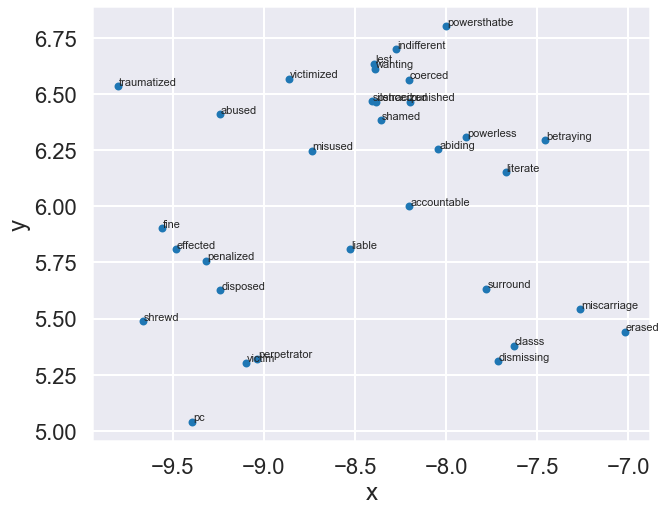

In [26]:
plot_region((-10,-7), (5,7)) # this cluster seems to have words of negative sentiment

                  word          x          y
1750           produce   8.604741  38.362782
2827              soil  10.604635  40.403084
3872       combination   9.431128  38.774742
4928              pill   8.457587  40.838985
5118        containing   8.053859  40.925610
...                ...        ...        ...
25128  methamphetamine   8.541757  41.291679
25354            carbs   9.583542  39.076607
25355         bandages   8.693375  39.417507
25589       inhibitors   8.729911  41.650925
25712           juicer   9.350340  38.679749

[70 rows x 3 columns]


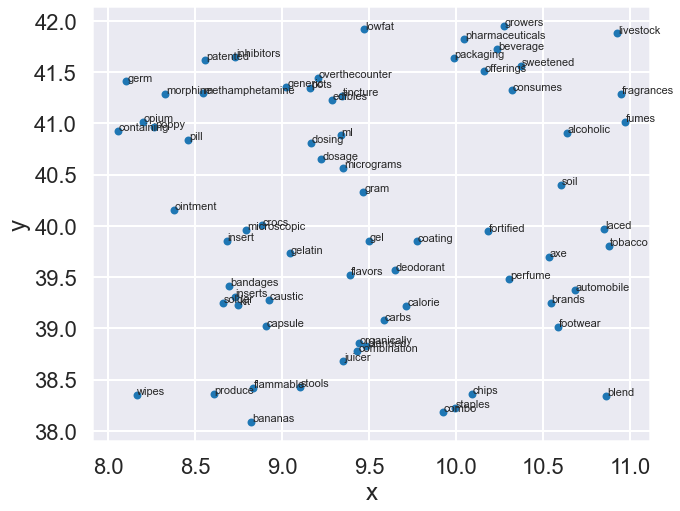

In [53]:
plot_region((8,11), (38,42))
# cluster of words of category commodities


In [27]:
# similar word relations
def nearest_similarity_cosmul(start1, end1, end2):
    similarities = fake_news.wv.most_similar_cosmul(
        positive=[end2, start1],
        negative=[end1]
    )
    start2 = similarities[0][0]
    print("{start1} is related to {end1}, as {start2} is related to {end2}".format(**locals()))
    return start2

In [127]:
fake_news.wv.most_similar('muslim',topn=20) # we can see a little bias against muslims in the articles

[('brotherhood', 0.5769191980361938),
 ('nonmuslim', 0.5538192391395569),
 ('freeloaders', 0.5401698350906372),
 ('somali', 0.5260658264160156),
 ('muslims', 0.5145555734634399),
 ('invaders', 0.5086599588394165),
 ('devout', 0.5038134455680847),
 ('holiest', 0.49648550152778625),
 ('nonmuslims', 0.49131011962890625),
 ('alsharif', 0.48706603050231934),
 ('colonizers', 0.4819066524505615),
 ('haram', 0.47822147607803345),
 ('symbolically', 0.47742658853530884),
 ('infidels', 0.47418057918548584),
 ('lgbtq', 0.47098174691200256),
 ('sharia', 0.4696749448776245),
 ('sympathizer', 0.46745672821998596),
 ('ramadan', 0.4665169417858124),
 ('cleric', 0.4638236463069916),
 ('mohamed', 0.46027126908302307)]

In [128]:
fake_news.wv.most_similar('trump',topn=20)

[('donald', 0.7037831544876099),
 ('trumps', 0.6235279440879822),
 ('temperamentally', 0.541790246963501),
 ('presidentelect', 0.5416078567504883),
 ('presumptive', 0.5281767249107361),
 ('temperamental', 0.5270350575447083),
 ('bigot', 0.5244831442832947),
 ('vitriol', 0.5228328108787537),
 ('bombastic', 0.5226311683654785),
 ('yuge', 0.5207566618919373),
 ('trumppence', 0.5177204608917236),
 ('heil', 0.5176429152488708),
 ('abedini', 0.5160935521125793),
 ('demagogic', 0.5160690546035767),
 ('demagogue', 0.5150882601737976),
 ('matchup', 0.5114219784736633),
 ('presidentelects', 0.5113869309425354),
 ('simpsons', 0.5107308626174927),
 ('birther', 0.5069953799247742),
 ('bernies', 0.5023117661476135)]

In [126]:
fake_news.wv.most_similar('clinton',topn=20) # similar words show some bias

[('hillary', 0.6611887812614441),
 ('clintons', 0.6345012187957764),
 ('hilary', 0.5463145971298218),
 ('rodham', 0.5447532534599304),
 ('posobiec', 0.5322608351707458),
 ('perjured', 0.528093159198761),
 ('robbie', 0.525062620639801),
 ('hillaryclinton', 0.5225754380226135),
 ('pinchuk', 0.521612823009491),
 ('paytoplay', 0.5207117795944214),
 ('snatch', 0.517021894454956),
 ('influencepeddling', 0.5158197283744812),
 ('hitlery', 0.511025071144104),
 ('superpac', 0.5101523399353027),
 ('presumptive', 0.5100210309028625),
 ('crooked', 0.5089322924613953),
 ('incestuous', 0.507810652256012),
 ('schoen', 0.5069400668144226),
 ('scandalridden', 0.5056212544441223),
 ('favoritism', 0.5024776458740234)]

In [31]:
nearest_similarity_cosmul("trump", "presidentelect", "clinton") # makes sense

trump is related to presidentelect, as hillary is related to clinton


'hillary'

In [49]:
nearest_similarity_cosmul("eyes", "body", "president")

eyes is related to body, as trashed is related to president


'trashed'

# LDA

In [55]:
df = pd.read_csv('Fake_news_Kaggle.csv', usecols = ['uuid','author','title','text','language','site_url','country'])
df = df[df.language == 'english']
df = df[df['text'].map(type) == str]
df['title'].fillna(value="", inplace=True)
df.dropna(axis=0, inplace=True, subset=['text'])
df = df.sample(frac=1.0)
df.reset_index(drop=True,inplace=True)
df.head()

,uuid,author,title,text,language,site_url,country
0,87a1bad8b50cc9ef5b37791cd4d267fce8b887ae,Author,Curious Alliances Taking Place Amid Mosul Oper...,"Country: Iraq As it always happens, a major mi...",english,journal-neo.org,RU
1,21a4e317edc20e475ac5456b93e3caad0cd8e45a,Howard Portnoy,Drunk coed attempting to take topless selfie w...,Print \nA tipsy Texas collegian was taking a t...,english,libertyunyielding.com,US
2,926f987eaa9ec723aba0d080f9b75e476de1d147,admin,On the Unbearable Lightness of Whiteness,On the Unbearable Lightness of Whiteness On th...,english,rinf.com,US
3,890eb2e6fee870935fa3a4c90d7a4ae39320d5bf,Pakalert,The Arrivals Bosanski Prijevod 15-hollywoodAnd...,Support Us The Arrivals Bosanski Prijevod 15-h...,english,pakalertpress.com,US
4,722fc468edebe7a6aa0462d9778204b8c40cd434,Mac Slavo,We Finally Know Why Hillary Disappeared On Ele...,As Donald Trump’s election to the highest offi...,english,shtfplan.com,US


In [57]:
def initial_clean(text):
    """
    Function to clean text of websites, email addresess and any punctuation
    We also lower case the text
    """
    text = re.sub("((\S+)?(http(s)?)(\S+))|((\S+)?(www)(\S+))|((\S+)?(\@)(\S+)?)", " ", text)
    text = re.sub("[^a-zA-Z ]", "", text)
    text = text.lower() # lower case the text
    text = nltk.word_tokenize(text)
    return text

stop_words = stopwords.words('english')
def remove_stop_words(text):
    """
    Function that removes all stopwords from text
    """
    return [word for word in text if word not in stop_words]

stemmer = PorterStemmer()
def stem_words(text):
    """
    Function to stem words, so plural and singular are treated the same
    """
    try:
        text = [stemmer.stem(word) for word in text]
        text = [word for word in text if len(word) > 1] # make sure we have no 1 letter words
    except IndexError: # the word "oed" broke this, so needed try except
        pass
    return text

def apply_all(text):
    """
    This function applies all the functions above into one
    """
    return stem_words(remove_stop_words(initial_clean(text)))

df['tokenized'] = df['text'].apply(apply_all) + df['title'].apply(apply_all)

In [58]:
all_words = [word for item in list(df['tokenized']) for word in item]
fdist = FreqDist(all_words)
len(fdist) # number of unique words

96280

In [68]:
k = 50000
top_k_words = fdist.most_common(k)
print(top_k_words[-10:])
print('----')
# choose k and visually inspect the bottom 10 words of the top k
k = 15000
top_k_words = fdist.most_common(k)
print(top_k_words[-10:])
 # we can see k=15000 is better since the words have more frequency.


[('selfbelief', 1), ('illusionari', 1), ('gadgetri', 1), ('ntervent', 1), ('selfrealis', 1), ('purposeto', 1), ('reenergis', 1), ('openhand', 1), ('technologybi', 1), ('countryclear', 1)]
----
[('badass', 13), ('breaker', 13), ('duran', 13), ('quasar', 13), ('petersen', 13), ('jewmerica', 13), ('flue', 13), ('compress', 13), ('indiarussia', 13), ('rajan', 13)]


In [66]:
# define a function only to keep words in the top k words
top_k_words,_ = zip(*fdist.most_common(k))
top_k_words = set(top_k_words)
def keep_top_k_words(text):
    return [word for word in text if word in top_k_words]

df['tokenized'] = df['tokenized'].apply(keep_top_k_words)


In [69]:
# document length
df['doc_len'] = df['tokenized'].apply(lambda x: len(x))
doc_lengths = list(df['doc_len'])
df.drop(labels='doc_len', axis=1, inplace=True)

print("length of list:",len(doc_lengths),
      "\naverage document length", np.average(doc_lengths),
      "\nminimum document length", min(doc_lengths),
      "\nmaximum document length", max(doc_lengths))

length of list: 12357 
average document length 345.66828518248764 
minimum document length 0 
maximum document length 11578


In [70]:
# only keep articles with more than 30 tokens, otherwise too short
df = df[df['tokenized'].map(len) >= 40]
# make sure all tokenized items are lists
df = df[df['tokenized'].map(type) == list]
df.reset_index(drop=True,inplace=True)
print("After cleaning and excluding short aticles, the dataframe now has:", len(df), "articles")

After cleaning and excluding short aticles, the dataframe now has: 10812 articles


In [71]:
df.head()

,uuid,author,title,text,language,site_url,country,tokenized
0,87a1bad8b50cc9ef5b37791cd4d267fce8b887ae,Author,Curious Alliances Taking Place Amid Mosul Oper...,"Country: Iraq As it always happens, a major mi...",english,journal-neo.org,RU,"[countri, iraq, alway, happen, major, militari..."
1,21a4e317edc20e475ac5456b93e3caad0cd8e45a,Howard Portnoy,Drunk coed attempting to take topless selfie w...,Print \nA tipsy Texas collegian was taking a t...,english,libertyunyielding.com,US,"[print, texa, take, topless, snapchat, photo, ..."
2,926f987eaa9ec723aba0d080f9b75e476de1d147,admin,On the Unbearable Lightness of Whiteness,On the Unbearable Lightness of Whiteness On th...,english,rinf.com,US,"[unbear, light, white, unbear, light, white, p..."
3,722fc468edebe7a6aa0462d9778204b8c40cd434,Mac Slavo,We Finally Know Why Hillary Disappeared On Ele...,As Donald Trump’s election to the highest offi...,english,shtfplan.com,US,"[donald, trump, elect, highest, offic, land, b..."
4,f6127d8027d26e5af8e4aa5a646865cd81727c6f,Shannon Barber,Texas Republican Calls Hillary The WORST Word ...,\nWith Hillary Clinton making history this e...,english,ifyouonlynews.com,US,"[hillari, clinton, make, histori, elect, seaso..."


### Split

In [76]:
msk = np.random.rand(len(df)) < 0.95
#splitting into train and test set

train_df = df[msk]
train_df.reset_index(drop=True,inplace=True)

test_df = df[~msk]
test_df.reset_index(drop=True,inplace=True)

In [77]:
print(len(df),len(train_df),len(test_df))


10812 10228 584


In [78]:
def train_lda(data):
    """
    This function trains the lda model
    We setup parameters like number of topics, the chunksize to use in Hoffman method
    We also do 2 passes of the data since this is a small dataset, so we want the distributions to stabilize
    """
    num_topics = 100
    chunksize = 300
    dictionary = corpora.Dictionary(data['tokenized'])
    corpus = [dictionary.doc2bow(doc) for doc in data['tokenized']]
    # low alpha means each document is only represented by a small number of topics, and vice versa
    # low eta means each topic is only represented by a small number of words, and vice versa
    lda = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary,
                   alpha=1e-2, eta=0.5e-2, chunksize=chunksize, minimum_probability=0.0, passes=2)
    return dictionary,corpus,lda

In [79]:
dictionary,corpus,lda = train_lda(train_df)

In [80]:
lda.show_topics(num_topics=10, num_words=20)
# we can see the top words contributing to the topic

[(12,
  '0.039*"air" + 0.031*"russian" + 0.031*"aircraft" + 0.031*"missil" + 0.029*"defens" + 0.026*"system" + 0.020*"militari" + 0.014*"base" + 0.012*"russia" + 0.012*"ship" + 0.012*"jet" + 0.012*"comment" + 0.011*"radar" + 0.010*"said" + 0.010*"target" + 0.009*"oper" + 0.009*"launch" + 0.009*"forc" + 0.009*"deploy" + 0.009*"carrier"'),
 (75,
  '0.060*"gun" + 0.025*"amend" + 0.021*"tax" + 0.017*"check" + 0.016*"ban" + 0.016*"american" + 0.013*"control" + 0.011*"support" + 0.010*"firearm" + 0.010*"second" + 0.010*"law" + 0.009*"fact" + 0.009*"rifl" + 0.009*"properti" + 0.009*"oppos" + 0.008*"would" + 0.008*"spend" + 0.008*"owner" + 0.008*"arm" + 0.008*"weapon"'),
 (80,
  '0.036*"studi" + 0.026*"health" + 0.025*"extract" + 0.024*"cancer" + 0.022*"research" + 0.018*"found" + 0.016*"also" + 0.015*"vitamin" + 0.013*"help" + 0.013*"diseas" + 0.011*"effect" + 0.011*"use" + 0.011*"blood" + 0.011*"diet" + 0.010*"one" + 0.010*"herb" + 0.010*"formula" + 0.010*"result" + 0.009*"dna" + 0.009*"hear

We can see topic 51 contains words related to finance and money, topic 70 is something to do with attacks

In [85]:
lda.show_topic(topicid=70, topn=20)


[('polic', 0.04458237),
 ('offic', 0.034310088),
 ('fire', 0.022834403),
 ('attack', 0.017065752),
 ('report', 0.016696097),
 ('cop', 0.013227334),
 ('shot', 0.013149011),
 ('kill', 0.012990287),
 ('shoot', 0.012119152),
 ('incid', 0.008668267),
 ('locat', 0.008519204),
 ('assault', 0.008391088),
 ('break', 0.0073720478),
 ('use', 0.007316716),
 ('two', 0.0072484636),
 ('peopl', 0.006845099),
 ('accord', 0.0067835897),
 ('one', 0.0066435304),
 ('wound', 0.0064991494),
 ('bomb', 0.00647404)]

In [129]:
lda.show_topic(topicid=51, topn=20)

[('money', 0.029827235),
 ('million', 0.025804108),
 ('fund', 0.019329889),
 ('compani', 0.016913565),
 ('foundat', 0.01451173),
 ('manag', 0.013793163),
 ('busi', 0.012172669),
 ('cash', 0.011596353),
 ('pay', 0.010883297),
 ('billion', 0.010610207),
 ('donor', 0.010587385),
 ('bank', 0.0101135885),
 ('work', 0.00964909),
 ('firm', 0.009574043),
 ('report', 0.009267695),
 ('financi', 0.009029448),
 ('year', 0.008984436),
 ('bill', 0.0084647965),
 ('invest', 0.008267757),
 ('donat', 0.008188399)]

In [84]:
lda.show_topic(topicid=9, topn=20)

[('state', 0.07225754),
 ('marijuana', 0.069291025),
 ('flower', 0.06377509),
 ('cannabi', 0.040576305),
 ('pot', 0.036647644),
 ('colorado', 0.034439642),
 ('alcohol', 0.03409106),
 ('legal', 0.032461353),
 ('use', 0.025890032),
 ('sale', 0.025388932),
 ('plant', 0.016165502),
 ('weed', 0.015163309),
 ('massachusett', 0.015025705),
 ('drug', 0.014351371),
 ('recreat', 0.0127060525),
 ('commut', 0.012566947),
 ('medic', 0.012153933),
 ('lanc', 0.011524619),
 ('permit', 0.011305867),
 ('overdos', 0.010523184)]

In [86]:
# select and article at random from train set
random_article_index = np.random.randint(len(train_df))
bow = dictionary.doc2bow(train_df.iloc[random_article_index,7])
print(random_article_index)

4812


In [87]:
print(train_df.iloc[random_article_index,3])

By George Zapo 
Posted Friday, October 28, 2016 at 08:04am EDT 
Keywords: Atlanta , food , food waste , fresh food , Georgia , hunger , landfills , perishable food , Second Helpings Atlanta , volunteers , waste managment 
Food waste and hunger are enormous global, environmental, and public health problems. As overwhelming as these issues are, community groups, volunteers, local businesses, and organizations are working on trying to find a solution. 
What started as a social action project in 2004, a few members of a small community in metro-Atlanta, Georgia took up the challenge to feed people in need and eliminate food waste. 
And they’re succeeding! 
The project grew into a non-profit organization with a team of more than 400 volunteer drivers, a network of more than 50 donors, and front-line agencies who feed the hungry on a daily basis. 
Amazingly, the entire group has rescued more than 5.5 million pounds of food — enough to provide 4.6 million meals. Here’s more of this motivating

In [88]:
doc_distribution = np.array([tup[1] for tup in lda.get_document_topics(bow=bow)])


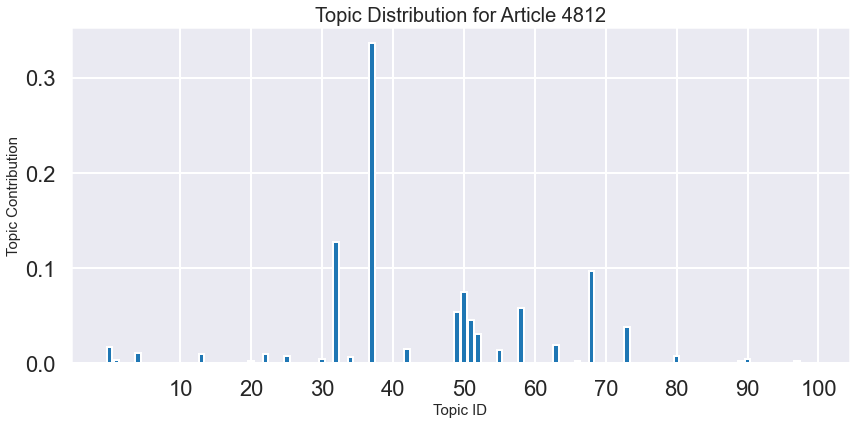

In [89]:
# bar plot of topic distribution for this document
fig, ax = plt.subplots(figsize=(12,6));
# the histogram of the data
patches = ax.bar(np.arange(len(doc_distribution)), doc_distribution)
ax.set_xlabel('Topic ID', fontsize=15)
ax.set_ylabel('Topic Contribution', fontsize=15)
ax.set_title("Topic Distribution for Article " + str(random_article_index), fontsize=20)
ax.set_xticks(np.linspace(10,100,10))
fig.tight_layout()
plt.show()

In [90]:
# print the top 5 contributing topics and their words
for i in doc_distribution.argsort()[-5:][::-1]:
    print(i, lda.show_topic(topicid=i, topn=10), "\n")

37 [('food', 0.06045976), ('water', 0.04455171), ('eat', 0.015816825), ('use', 0.014970428), ('plant', 0.012776879), ('also', 0.011320796), ('drink', 0.010807287), ('organ', 0.010442977), ('fat', 0.0075081484), ('suppli', 0.0070757843)] 

32 [('get', 0.017064197), ('like', 0.016875785), ('go', 0.013889824), ('would', 0.01366536), ('peopl', 0.013425156), ('one', 0.01221207), ('thing', 0.01151097), ('want', 0.011495419), ('make', 0.011448477), ('even', 0.011120047)] 

68 [('year', 0.01863034), ('increas', 0.016290823), ('product', 0.016091676), ('compani', 0.014180221), ('cost', 0.013280045), ('percent', 0.012736963), ('bond', 0.012639052), ('new', 0.01186175), ('report', 0.010619115), ('industri', 0.01026465)] 

50 [('children', 0.04932138), ('famili', 0.044326007), ('child', 0.029849112), ('live', 0.025815904), ('parent', 0.025644353), ('young', 0.02438383), ('mother', 0.018842688), ('song', 0.018334832), ('boy', 0.016573386), ('age', 0.0154292835)] 

58 [('said', 0.022280246), ('meet'

### Similiarity queries and Unseen data

In [91]:
# select and article at random from test set
random_article_index = np.random.randint(len(test_df))
print(random_article_index)


364


In [92]:
new_bow = dictionary.doc2bow(test_df.iloc[random_article_index,7])

print(test_df.iloc[random_article_index,3])


0 comments He and Huma Abedin interned for the Clintons and rose to power. Now WikiLeaks has exposed the truth about all of them… At age 22, Doug Band started interning for President William Jefferson Clinton. Later, he earned a law degree, and became Bill Clinton’s top assistant. He is Bill Clinton’s version of Huma Abedin, and the connections between Band and Abedin are also tightly woven in to the fabric of the Clinton story. He became a talented negotiator. According to the bio on his company website (Teneo,) Doug Band was “part of the negotiation team that handled all aspects of Hillary Clinton’s becoming secretary of state.” Prior to that, in 2005, Band himself conceived the idea of the Clinton Global Initiative. The money flowed in like a tidal wave. In a scandal that has been brewing for more than a decade now, it is said that Doug Band “shook down” countless donors. The pitch was simple: give to the Clinton Global Initiative/The Clinton Foundation, and reap the benefits of Bil

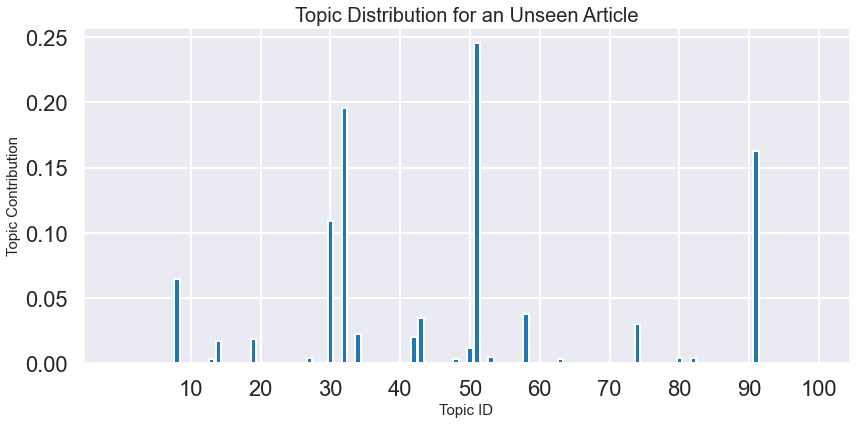

In [93]:
new_doc_distribution = np.array([tup[1] for tup in lda.get_document_topics(bow=new_bow)])

# bar plot of topic distribution for this document
fig, ax = plt.subplots(figsize=(12,6));
# the histogram of the data
patches = ax.bar(np.arange(len(new_doc_distribution)), new_doc_distribution)
ax.set_xlabel('Topic ID', fontsize=15)
ax.set_ylabel('Topic Contribution', fontsize=15)
ax.set_title("Topic Distribution for an Unseen Article", fontsize=20)
ax.set_xticks(np.linspace(10,100,10))
fig.tight_layout()
plt.show()

In [96]:
#seeing the top topics of the unseen article
for i in new_doc_distribution.argsort()[-5:][::-1]:
    print(i, lda.show_topic(topicid=i, topn=10), "\n")


51 [('money', 0.029827235), ('million', 0.025804108), ('fund', 0.019329889), ('compani', 0.016913565), ('foundat', 0.01451173), ('manag', 0.013793163), ('busi', 0.012172669), ('cash', 0.011596353), ('pay', 0.010883297), ('billion', 0.010610207)] 

32 [('get', 0.017064197), ('like', 0.016875785), ('go', 0.013889824), ('would', 0.01366536), ('peopl', 0.013425156), ('one', 0.01221207), ('thing', 0.01151097), ('want', 0.011495419), ('make', 0.011448477), ('even', 0.011120047)] 

91 [('email', 0.0724539), ('clinton', 0.06923105), ('hillari', 0.018150743), ('fbi', 0.01636618), ('server', 0.014546781), ('investig', 0.013092003), ('abedin', 0.012727153), ('weiner', 0.012670684), ('state', 0.012481875), ('huma', 0.011826994)] 

30 [('clinton', 0.19682355), ('hillari', 0.15241815), ('bill', 0.025441691), ('presid', 0.020890338), ('support', 0.011025143), ('campaign', 0.009218115), ('endors', 0.008998901), ('lie', 0.008529022), ('corrupt', 0.007092419), ('candid', 0.0068013147)] 

8 [('one', 0.01

In [105]:
doc_topic_dist = np.array([[tup[1] for tup in lst] for lst in lda[corpus]])
doc_topic_dist.shape

(10228, 100)

In [118]:
def jensen_shannon(query, matrix):
    """
    This function implements a Jensen-Shannon similarity
    between the input query (an LDA topic distribution for a document)
    and the entire corpus of topic distributions.
    It returns an array of length M where M is the number of documents in the corpus
    """
    p = query[None,:].T + np.zeros([100, doc_topic_dist.shape[0]] )
    q = matrix.T # transpose matrix
    m = 0.5*(p + q)
    return np.sqrt(0.5*(entropy(p,m) + entropy(q,m)))

In [119]:
def get_most_similar_documents(query,matrix,k=10):
    """
    This function implements the Jensen-Shannon distance above
    and retruns the top k indices of the smallest jensen shannon distances
    """
    sims = jensen_shannon(query,matrix) # list of jensen shannon distances
    return sims.argsort()[:k] # the top k positional index of the smallest Jensen Shannon distances

In [121]:
from scipy.stats import entropy
most_sim_ids = get_most_similar_documents(new_doc_distribution,doc_topic_dist)

In [122]:
most_similar_df = train_df[train_df.index.isin(most_sim_ids)]
most_similar_df['title']
#these are the articles most similar to the test set article chosen

485     Wikileaks Releases Clinton Foundation BOMBSHEL...
1014    Clinton aide’s for-profit firm illegally raise...
1218    If Hillary Wrote An Honest Book, Here’s What I...
1275    Inside ‘Bill Clinton Inc.’: Hacked memo reveal...
3520    Leaked Memo Exposes Shady Dealings Between Cli...
5126    Clinton Network Concerned About Teneo’s Consul...
6249    WikiLeaks: Clinton Confidant Raised Money for ...
7561    Leaked Memo Exposes Shady Dealings Between Cli...
7634    WikiLeaks: Clinton Confidant Raised Money for ...
9959    Aide Said He Was Running 'Bill Clinton Inc.' i...
Name: title, dtype: object

In [125]:
most_similar_df['text'][485]

'Home » Headlines » World News » Wikileaks Releases Clinton Foundation BOMBSHELL: “If This Story Gets Out, We Are Screwed” “If This Story Gets Out, We Are Screwed” John, I would appreciate your feedback and any suggestions I’m also starting to worry that if this story gets out, we are screwed… We’ve been waiting for a SMOKING GUN Wikileaks release. Today, it appears we got just that, courtesy an email from Doug Band to Cheryl Mills and John Podesta dated November 12, 2011. \nBand sent Podesta an email concerned that Bill and Hillary’s daughter Chelsea was threatening business as usual at the Clinton Foundation, and apparently was concerned the Clinton daughter would discover the true extent of the criminal fraud and corruption, telling Podesta, “ if this story gets out, we are screwed.” Was Comey’s FBI letter to Congress on Friday merely a ploy to distract media attention from a SMOKING GUN Wikileaks release? \nDecide for yourself… \nFull Wikileaks email : \nNeed get this asap to them 

## References

#### 1.  KTattan, LDA and Document Similarity, Kaggle
#### 2. Ktattan, fake2Vec, Kaggle